# Example notebook for analysing and plotting the paper figures in Google Colab
### [OpenScope Credit Assignment repository](https://github.com/colleenjg/OpenScope_CA_Analysis)
### [Gillon _et al._, 2021, _bioRxiv_](https://www.biorxiv.org/content/10.1101/2021.01.15.426915v2)


---
## 1. Setup

In [1]:
# @markdown ### a. Download code from the **OpenScope_CA_Analysis** repository on GitHub.

%%bash

# ensure that we are in the main directory
cd /content 

# If the repository does not already exist, download it.
if [ -d "OpenScope_CA_Analysis" ]; then
    echo "OpenScope_CA_Analysis repository has already been downloaded."
else
    echo "Downloading OpenScope_CA_Analysis main branch from GitHub..."
    git clone --single-branch --branch main https://github.com/colleenjg/OpenScope_CA_Analysis.git --quiet
fi

In [2]:
# @markdown ### b. Install required python packages. 
# @markdown ### **Note:** The kernel will be restarted to ensure the proper package versions are loaded.

print("Installing required packages...\n")

!pip --quiet install -U matplotlib!=3.7.0
!pip --quiet install -r OpenScope_CA_Analysis/requirements.txt

print("\nRestarting kernel...")
get_ipython().kernel.do_shutdown(True);

Installing required packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.2/223.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.6/126.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 =============================
### **_Once the kernel has restarted, continue running the cells_**
 =============================

### c. Download data from  the [Dandi archive](https://gui.dandiarchive.org/#/dandiset/000037).
Here, we will only download **session 1 data** (11 files) for all subjects, into a directory called `data`, at the same level as the `OpenScope_CA_Analysis` directory.

To do so, we first **move into the `OpenScope_CA_Analysis` repository**, from which we can launch scripts.

We then **download the data** using `sess_util/sess_download_util.py`. This will take a few minutes. 

**Note:** Any files that _already_ exist in the data directory (and pass the checksum) will be skipped, and **not** redownloaded.

In [2]:
%cd -q /content/OpenScope_CA_Analysis

print("Downloading data from Dandi (may take a few minutes)...\n")
%run sess_util/sess_download_util.py --sess_ns 1 --output ../data

Identifying the URLs of dandi assets to download...


PATH                                        SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-408021_ses-758519303_behavior+ophys.nwb 238.0 MB 238.0 MB         100%    ok    done                   
Summary:                                    238.0 MB 238.0 MB                       1 done                 
                                                     100.00%                                               
PATH                                        SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-411771_ses-760260459_behavior+ophys.nwb 230.3 MB 230.3 MB         100%    ok    done                   
Summary:                                    230.3 MB 230.3 MB                       1 done                 
                                                     100.00%                                               
PATH                                        SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-411424_ses-761624763_beh

---
## 2. Adjust a few settings in the notebook

In [3]:
# @markdown - Change Google Colab display to wrap text to window size.
# Code from https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# @markdown - Set an environment variable that controls maximum memory use when 
# @markdown performing permutation analyses.
%env LIM_E6_SIZE=100

# @markdown - Filter warnings related to multiprocessing performance.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="A worker stopped")

# @markdown - Set logging and warnings format.
from util import logger_util
logger_util.format_all(level='info')

# @markdown - Pre-load matplotlib.
# The first plot never seems to appear inline, so we plot a dummy plot.
from matplotlib import pyplot as plt
plt.plot(range(20))
plt.close("all")

# @markdown - Download fonts for plotting. 
# Fonts stored under "../tools/fonts" are added to the matplotlib font 
# manager when run_paper_figures.py runs.
from pathlib import Path
from util import plot_util

filenames = ["Arial.ttf", "ArialBold.ttf"]
urls = ["https://www.img.download-free-fonts.com/dl.php?id=70792&hash=3efa23b280ec76cbc2d1649b5462c05b", 
        "https://www.img.download-free-fonts.com/dl.php?id=70108&hash=3bac649a2e686e40c06b76063b5ced9a"]

filepaths = []
for filename, url in zip(filenames, urls):
    filepath = Path("/content", "tools", "fonts", filename)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    
    !wget -q -O "$filepath" "$url" # if this hangs, there might be a problem with the links 

plot_util.update_font_manager(fontdir=filepath.parent) 


env: LIM_E6_SIZE=100


---
## 3. Run paper analyses

All subsequent code should be run from inside the OpenScope_CA_Analysis repository.

In [4]:
%cd -q /content/OpenScope_CA_Analysis

We can now run some paper analyses and plot them.

We use the `run_paper_figures.py` script in the main directory of the OpenScope_CA_Analysis directory, with the following arguments:
- `datadir`: path to the downloaded data
- `output`: main directory in which to store the analysis data and plots
- `overwrite`: if included, existing analysis data and plots are overwritten
- `paper`: paper for which to plot figures (`dataset` or `analysis`)
- `figure`: figure to plot (either `all` or a specific figure)
- `panel`: panel to plot (either `all` or a specific panel)
- `parallel`: if included, analyses are parallelized across available CPUs


In [5]:
# Uncomment the code below to see descriptions for all arguments
# %run run_paper_figures.py --help

### Fig. 1C



________________________________________________________________________________
Fig. 1C (analysis paper). Running analysis and producing plot: Example projections of 2p imaging planes.

- Minor manual formatting adjustments may be missing.

Loading 4 session(s)...


  0%|          | 0/4 [00:00<?, ?it/s]


Compiling imaging plane projection examples.
    Rasterizing imaging plane images...

Figures saved under /content/paper_figures/analysis_paper/Fig1.
Duration: 28.71s


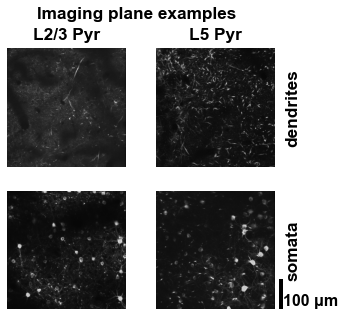

In [6]:
%run run_paper_figures.py --overwrite --paper analysis --figure 1 --panel C --parallel --datadir /content/data --output /content 

### Fig. 2E, but with lower statistical power
Here, we run the analysis without the `--full_power` argument, in order to reduce compute time and memory demands. 

This means that, for this panel, fewer random permutations (here, `1e3` instead of `1e4`) are used in order to calculate each ROI's USI null distribution, and resulting significance percentile. The exact distributions plotted may therefore differ slightly from those plotted in the paper, although they should be qualitatively the same.

The results (analysis data and plot) are saved under a subfolder called `panels_with_diff_params`.



________________________________________________________________________________
Fig. 2E (analysis paper). Running analysis and producing plot: Distributions of Gabor USI percentiles.

- Minor manual formatting adjustments may be missing.
- Reducing number of permutations/shuffles to reduce computation time. This weakens statistical power for significance testing a bit, potentially producing results that differ just slightly from published results. To reproduce paper results exactly, run script with the '--full_power' argument.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling Gabor ROI USI distributions.
    Calculating ROI USIs and their null distributions for each session...

Figures saved under /content/paper_figures/analysis_paper/Fig2/panels_with_diff_params.
Duration: 3m 46.54s


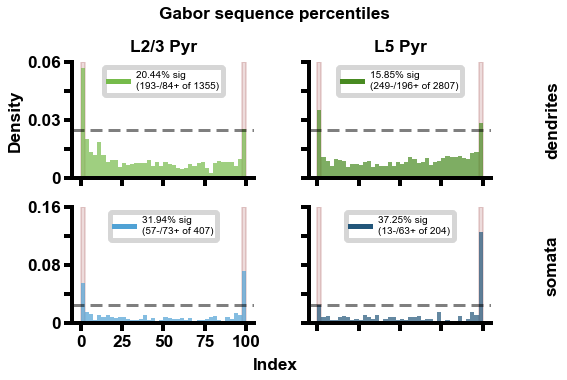

In [7]:
%run run_paper_figures.py --overwrite --paper analysis --figure 2 --panel E --parallel --datadir /content/data --output /content 

### Fig. 3, with full statistical power
Here, we run the analyses with the `--full_power` argument, and thus should be able to exactly reproduce the p-values reported in the paper.



________________________________________________________________________________
Fig. 3A (analysis paper). Running analysis and producing plot: Running and pupil responses to Gabor sequences.

- Minor manual formatting adjustments may be missing.
- Running and pupil images will be missing.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling pupil and running sequences for session 1.

Figures saved under /content/paper_figures/analysis_paper/Fig3.
Duration: 1m 38.38s


Fig. 3B (analysis paper). Running analysis and producing plot: Trial differences in running and pupil responses U-G vs D-G Gabor sequences.

- Minor manual formatting adjustments may be missing.

Compiling pupil and running block differences for session 1.

Raw p-values (two-tailed):
    Running velocity:    L2/3-D: 0.96460       L2/3-S: 0.27680       L5-D: 0.80780       L5-S: 0.44040   
    Pupil diameter  :    L2/3-D: 0.89240       L2/3-S: 0.19560       L5-D: 0.96880       L5-S: 0.26840   

Figures saved under /content/paper_figures/analysis_paper/Fig3.
Duration: 35.49s


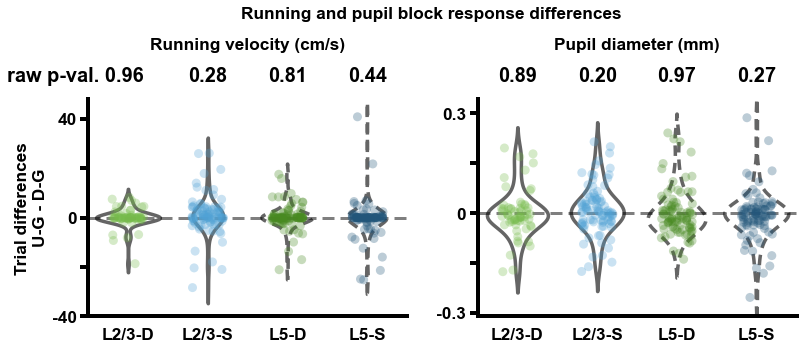

In [8]:
%run run_paper_figures.py --overwrite --paper analysis --figure 3 --panel all --parallel --full_power --datadir /content/data --output /content 

### Fig. 3B, with a different random seed

By default, the script uses the same random process seed as was used for the paper. Here, however, we run the analysis with a different seed, i.e. `100`. This means that the exact p-values obtained may differ slightly from those reported in the paper, although they should be qualitatively the same.

The results (analysis data and plot) are saved under a subfolder called `panels_with_diff_params`, with the seed number recorded in the file names.



________________________________________________________________________________
Fig. 3B (analysis paper). Running analysis and producing plot: Trial differences in running and pupil responses U-G vs D-G Gabor sequences.

- Minor manual formatting adjustments may be missing.
- Using a different seed from the one used in the paper: 100. Results may differ slightly from published results. To use paper seed, run script with default seed argument, i.e., '--seed paper'.

Loading 11 session(s)...


  0%|          | 0/11 [00:00<?, ?it/s]


Compiling pupil and running block differences for session 1.

Raw p-values (two-tailed):
    Running velocity:    L2/3-D: 0.98160       L2/3-S: 0.28240       L5-D: 0.79880       L5-S: 0.44160   
    Pupil diameter  :    L2/3-D: 0.92840       L2/3-S: 0.19920       L5-D: 0.97540       L5-S: 0.28180   

Figures saved under /content/paper_figures/analysis_paper/Fig3/panels_with_diff_params.
Duration: 1m 37.64s


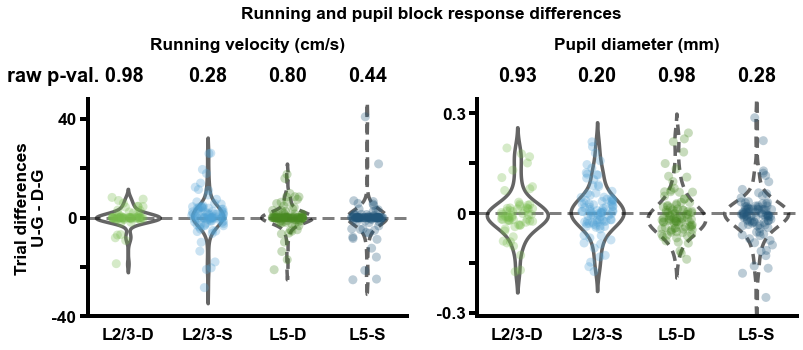

In [9]:
seed = 100
%run run_paper_figures.py --overwrite --paper analysis --figure 3 --panel B --parallel --full_power --seed $seed --datadir /content/data --output /content 

---
## 4. Final Notes

For most other figures and panels, the remaining sessions **(sessions 2 and 3)** must also be downloaded. This can be done by returning to **Step 1d**, and rerunning the download with the argument `--sess_ns 1-3`.

Notably, though, the analyses for some panels are:
- **computationally expensive**: generally, this applies to analyses involving lots of statistical significance comparisons, e.g. Fig. 4B.  
- **long**: this is particularly the case for the decoder analyses in Fig. 5A-B.

For this reason, they are best run on a **high performance compute device** (e.g., 16+ cores and 32+ GB of RAM).